<a href="https://colab.research.google.com/github/YardenGoraly/Mujoco_fun/blob/main/MuJoCo_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Initial setup, you shouldn't have to modify this code

%pip install mujoco
%pip install mediapy

import platform
import os
import subprocess
import mediapy as media

# Detect the operating system and configure GPU rendering accordingly.
if platform.system() == "Linux":
    # Assume Nvidia GPU is present.
    if subprocess.run("nvidia-smi", shell=True).returncode != 0:
        raise RuntimeError(
            "Cannot communicate with GPU. Make sure you are using a GPU runtime."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")
    print("Setting environment variable for Nvidia GPU rendering (EGL).")
    os.environ["MUJOCO_GL"] = "egl"

elif platform.system() == "Darwin":
    # Assume running on macOS (Apple Silicon).
    print("Running on macOS. Setting environment variable for GPU rendering using GLFW.")
    os.environ["MUJOCO_GL"] = "glfw"

    media.set_ffmpeg("/opt/homebrew/bin/ffmpeg")
else:
    print("Unsupported platform. GPU rendering might not be configured correctly.")

# Check if MuJoCo installation was successful.
try:
    import mujoco as mj
    mj.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise RuntimeError(
        "Something went wrong during MuJoCo installation. Check the shell output above for more information."
    ) from e

print("MuJoCo installation successful.")

# Other imports and helper functions.
import time
import itertools
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Graphics and plotting.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# On Linux, ensure ffmpeg is installed (this is not applicable on macOS).
if platform.system() == "Linux":
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

%pip install -q mediapy
import mediapy as media

from IPython.display import clear_output
clear_output()


In [2]:
#More setup 
%pip install robot_descriptions
%pip install dm_control

from robot_descriptions import panda_mj_description
from IPython.display import HTML
from robot_descriptions.loaders.mujoco import load_robot_description
from dm_control import mjcf
import dm_control
import PIL.Image


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get XML for Sawyer, hand, and ball
ball_xml = """
<mujoco model="ball">
    <worldbody>
        <body name="ball_body" pos="0.8 0.2 0.04">
            <geom name="ball_geom" mass="0.01" friction="1" type="sphere" solref="0.01 0.5" size="0.05" rgba="1 0 0 1"/>
        </body>
    </worldbody>
</mujoco>
"""
hand_path = "mujoco_menagerie/wonik_allegro/right_hand.xml"
sawyer_path = "mujoco_menagerie/rethink_robotics_sawyer/sawyer.xml"

In [4]:
# Define Models
hand_model = mjcf.from_path(hand_path)
sawyer_model = mjcf.from_path(sawyer_path)
ball_model = mjcf.from_xml_string(ball_xml)

# Fingertips in XML are not actually at the tip, so we add a body with an offset
ff_tip = hand_model.find('body', 'ff_tip')
ff_tip.add('body', name='ff_tip_rubber', pos=[0, 0, 0.02])
mf_tip = hand_model.find('body', 'mf_tip')
mf_tip.add('body', name='mf_tip_rubber', pos=[0, 0, 0.02])
rf_tip = hand_model.find('body', 'rf_tip')
rf_tip.add('body', name='rf_tip_rubber', pos=[0, 0, 0.02])
th_tip = hand_model.find('body', 'th_tip')
th_tip.add('body', name='th_tip_rubber', pos=[0, 0, 0.02])

MJCF Element: <body name="th_tip_rubber" pos="0 0 0.02"/>

In [5]:
# Attach hand to the Sawyer
arena = mjcf.RootElement()
sawyer_site = sawyer_model.find('site', 'attachment_site')
attachment_frame = arena.attach(ball_model)
sawyer_site.attach(hand_model)
arena.attach(sawyer_model)

# Set up scene
sky = arena.asset.add('texture', type='skybox', builtin="gradient", rgb1=[0, .2, 1], 
                      rgb2="1 1 1", width=512, height=512)
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=500,
                            height=500, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[30, 30], reflectance=.1)
arena.worldbody.add('geom', type='plane', size=[10, 10, 10], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])
for y in [-2, 2]:
  arena.worldbody.add('light', pos=[-1, y, 3], dir=[1, -y, -2], attenuation=[3, 0, 0], castshadow=False)
arena.worldbody.add('camera', name='camera_1', pos=[-1, -1, 1], euler=[1.5, -0.5, 0])
arena.worldbody.add('camera', name='camera_2', pos=[-1, -1, 0.3], euler=[1.55, 2, 0])

# Add freejoint to ball so it can move freely
attachment_frame.add('joint', name='ball_joint', type='free', armature='0.00000175')

# Extract ball elements to read attributes
ball_body = ball_model.find('body', 'ball_body')
ball_geom = ball_model.find('geom', 'ball_geom')

In [6]:
from multifingered_ik import LevenbergMarquardtIK

# Some util functions as suggestions, you may or may not use them
def generate_ball_contact_points():
    """
    Generates contact points for each finger on the surface of the ball
    """
    #YOUR CODE HERE

def calculate_ball_contact_normals(contact_points: np.array, ball_center: np.array):
    """
    Input: array of contact points
    Return: array of normal vectors on the ball for each contact
    """
    #YOUR CODE HERE

def set_camera_position(physics, camera_name, camera_position):
    camera_id = physics.model.name2id(camera_name, "camera")
    physics.named.model.cam_pos[camera_name] = camera_position
    return camera_id

def set_initial_configuration(physics):
    initial_qpos = [0, 0, 0, 0, 0, 0, 0, 0, -0.8, 0, 2, 0, -1.2, 3.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    physics.data.qpos[:] = initial_qpos

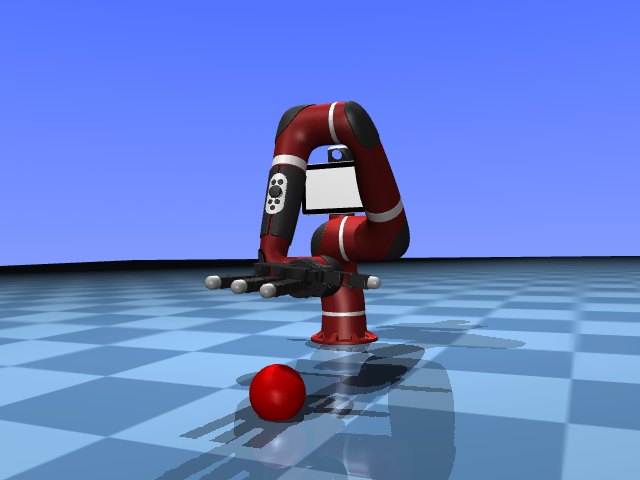

In [18]:
# Define ball attributes
ball_radius = ball_geom.size[0]
ball_center = np.array(ball_body.pos)

physics = mjcf.Physics.from_mjcf_model(arena)

# Init scene
camera_id = set_camera_position(physics, "camera_1", [0.3, -0.5, 0.1])
camera_id2 = set_camera_position(physics, "camera_2", [1.7, 0.7, 0.3])
set_initial_configuration(physics)

physics.forward()
PIL.Image.fromarray(physics.render(height=480, width=640, camera_id=camera_id2))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

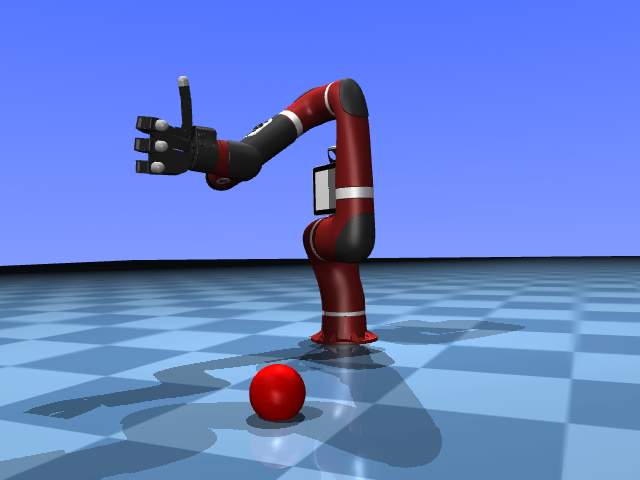

In [25]:
# Here you can test your IK solver
#Use IK to get the joint states of your target positions.
set_initial_configuration(physics)
body_names = ['sawyer/allegro_right/palm', 'sawyer/allegro_right/ff_tip_rubber', 'sawyer/allegro_right/mf_tip_rubber', 'sawyer/allegro_right/rf_tip_rubber', 'sawyer/allegro_right/th_tip_rubber']
body_positions = [[ 0.674, -0.185, 0.524], [ 0.723, -0.113, 0.56 ], [ 0.723, -0.118, 0.516], [ 0.736, -0.113, 0.469], [ 0.601, -0.143, 0.67 ]]
body_orientations = [[-0.626, -0.589, -0.392, -0.329], [ 0.33 , 0.305, -0.676, -0.584], [ 0.347, 0.286, -0.652, -0.61 ], [ 0.017, -0.071, -0.724, -0.686], [-0.967, 0.061, 0.029, 0.245]]

step_size = 0.05
tol = 0.01
alpha = 0.05
damping = 0.05
max_steps = 1000
jacp = np.zeros((3, physics.model.nv), dtype=np.float64, order='C')
jacr = np.zeros((3, physics.model.nv), dtype=np.float64, order='C')
Ik = LevenbergMarquardtIK(physics.model, physics.data, step_size, tol, alpha, jacp, jacr, damping, max_steps, physics)

newpos = Ik.calculate(body_positions, body_orientations, body_names)
physics.data.qpos[:] = newpos

physics.forward()
PIL.Image.fromarray(physics.render(height=480, width=640, camera_id=camera_id2))

In [26]:
from PIL import Image

physics.forward()

# Render without depth buffer
img = physics.render(height=480, width=640, camera_id=camera_id2, depth=False)

# Convert and show
image = Image.fromarray(img)
image.show()

In [10]:
from AllegroHandEnv import AllegroHandEnvSphere
from grasp_synthesis import synthesize_grasp

# Run grasp synthesis algorithm to generate force closure hand onfiguration

In [11]:
# Here are some flags you can set to visualize contact forces
# We suggest that you visualize the results of your grasp synthesis algorithm when debugging
# Visualize contact frames and forces, make body transparent
options = mj.MjvOption()
mj.mjv_defaultOption(options)
options.flags[mj.mjtVisFlag.mjVIS_CONTACTPOINT] = False
options.flags[mj.mjtVisFlag.mjVIS_CONTACTFORCE] = False
options.flags[mj.mjtVisFlag.mjVIS_TRANSPARENT] = False

# tweak scales of contact visualization elements
physics.model.ptr.vis.scale.contactwidth = 0.1
physics.model.ptr.vis.scale.contactheight = 0.03
physics.model.ptr.vis.scale.forcewidth = 0.05
physics.model.ptr.vis.map.force = 0.05

C:\Users\jiand\AppData\Local\Temp\ipykernel_4832\897899858.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[2].set_yscale('log')


Text(0, 0.5, 'Newton')

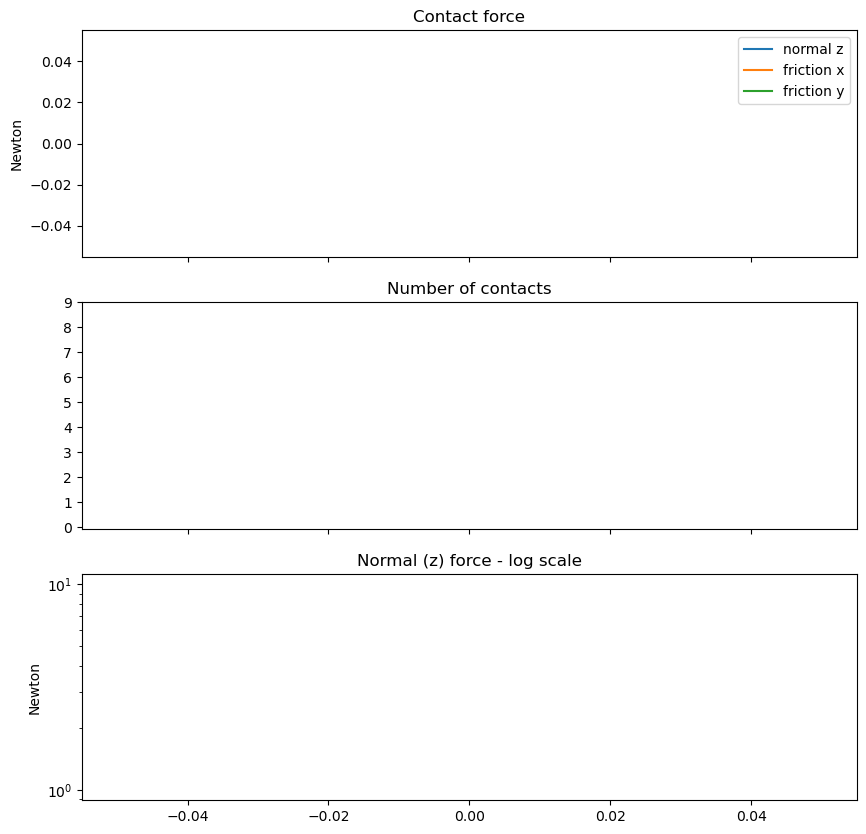

In [12]:
# Here's some skeleton code to run a control loop in MuJoCo
# This is just an initial suggestion, so feel free to change anything about it

duration = 5
framerate = 30
dt = 1 / (duration * framerate)
video = []
n_steps = 200

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
forcetorque = np.zeros(6)

physics.reset()

# Initialize state
#YOUR CODE HERE

# Run control loop
with mj.Renderer(physics.model.ptr, 480, 640) as renderer:
    for i in range(n_steps):
        while physics.data.time * framerate < i:
            # Control robot and collect data for plotting
            #YOUR CODE HERE

            physics.step()
        # Render scene, feel free to change camera
        renderer.update_scene(physics.data.ptr, "camera_2", options)
        frame = renderer.render()
        video.append(frame)

# Plot
# This is just to serve as an example for plotting. You'll likely have to make some changes for the deliverables
_, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

lines = ax[0].plot(sim_time, force)
ax[0].set_title('Contact force')
ax[0].set_ylabel('Newton')
ax[0].legend(list(lines), ('normal z', 'friction x', 'friction y'))
ax[1].plot(sim_time, ncon)
ax[1].set_title('Number of contacts')
ax[1].set_yticks(range(10))

ax[2].plot(sim_time, force[:,0])
ax[2].set_yscale('log')
ax[2].set_title('Normal (z) force - log scale')
ax[2].set_ylabel('Newton')


In [13]:
# Display video
media.show_video(video, fps=30)

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.